In [1]:
! pip install --quiet \
"setuptools==59.5.0" \
"pytorch-lightning>=1.4" \
"matplotlib" "torch>=1.8" \
"ipython[notebook]" \
"torchmetrics>=0.7" \
"torchvision" \
"seaborn" \
"opencv-python"

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
import string
from torchmetrics import CharErrorRate
import torch.nn.functional as F

In [ ]:
def accuracy(preds, target):
    N = len(preds) 
    accurate = 0
    for i in range(len(preds)):
        if preds[i] == target[i]:
            accurate += 1
    return accurate/N

Соберем все символы, которые могут встретиться в датасете для последущего кодирования

In [182]:
#Провинции в Китае, иероглифы которых могут встретиться на автомобильных номерах
dict_provinces = {
    '粤': 'Гуандун', 
    '黑': 'Хэйлунцзян',
    '蒙': 'Автономный район Внутренняя Монголия',
    '琼': 'Хайнань',
    '辽': 'Ляонин',
    '鲁': 'Шаньдун',
    '贵': 'Фуцзянь',
    '浙': 'Чжецзян',
    '新': 'Синьцзян-Уйгурский Автономный Район',
    '吉': 'Провинция Цзилинь',
    '皖': 'Аньхой',
    '甘': 'Ганьсу',
    '闽': 'Гуйчжоу',
    '冀': 'Хэбэй',
    '豫': 'Хэнань',
    '鄂': 'Хубэй',
    '湘': 'Хунань',
    '苏': 'Цзянсу',
    '赣': 'Цзянси',
    '青': 'Цинхай',
    '陕': 'Шэньси',
    '晋': 'Шаньси',
    '川': 'Сычуань',
    '云': 'Юньнань',
    '桂': 'Гуанси-Чжуанский Автономный Округ',
    '宁': 'Нинся-Хуэйский Автономный Округ',
    '藏': 'Автономный Округ Тибет',
    '京': 'Beijing',
    '渝': 'Chongqing',
    '沪': 'Shanghai',
    '津': 'Tianjin'
}

NUMBER = list(string.digits)
ALPHABET = list(string.ascii_uppercase) 
Hieroglyphics = list(dict_provinces.keys())
ALL_CHAR_SET = NUMBER + ALPHABET + Hieroglyphics
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)

In [183]:
ALL_CHAR_SET_LEN, len(Hieroglyphics)

(67, 31)

In [184]:
data_path = '/Users/alenabuk/Downloads/CCPD2019-dl1'

(62, 181, 3)


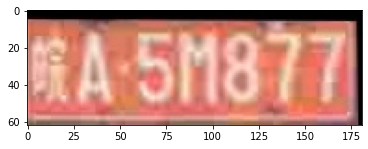

In [188]:
#Загрузим для примера картинку из train
img = cv2.imread(data_path + '/train/01-皖A5M877.jpg')
print(img.shape)
plt.imshow(img)

In [189]:
#Определим размеры картинок в train
cnt, mean_h, mean_w = 0, 0, 0
for i in os.listdir(data_path + '/train'):
    img = cv2.imread(data_path + '/train/' + f'{i}')
    
    if cnt == 0:
        min_shape_h, max_shape_h = img.shape[0], img.shape[0]
        min_shape_w, max_shape_w = img.shape[1], img.shape[1]

    if img.shape[0] > max_shape_h:
        max_shape_h = img.shape[0]
        max_img_h = img
    if img.shape[0] < min_shape_h:
        min_shape_h = img.shape[0]
        min_img_h = img
        
    if img.shape[1] > max_shape_w:
        max_shape_w = img.shape[1]
        max_img_w = img
    if img.shape[1] < min_shape_w:
        min_shape_w = img.shape[1] 
        min_img_w = img
        
    h, w = img.shape[0], img.shape[1]
    
    mean_h = ((mean_h * cnt) + h)/(cnt + 1)
    mean_w = ((mean_w * cnt) + w)/(cnt + 1)
    cnt += 1

In [190]:
# (наименьший, наибольший, средний) по высоте размер картинки
min_shape_h, max_shape_h, mean_h

(28, 239, 84.81559155915525)

In [191]:
# (наименьший, наибольший, средний) по ширине размер картинки
min_shape_w, max_shape_w, mean_w

(74, 719, 249.84530453045298)

In [192]:
#картинка с наибольшим значением по высоте
max_img_h.shape

(239, 692, 3)

In [193]:
#картинка с наибольшим значением по ширине
max_img_w.shape

(211, 719, 3)

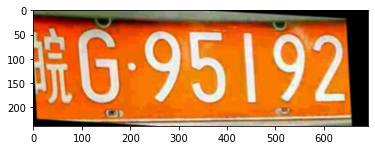

In [194]:
#Посмотрим на самую высокую картинку
plt.imshow(transforms.ToPILImage()(transforms.ToTensor()(max_img_h)), interpolation="bicubic")

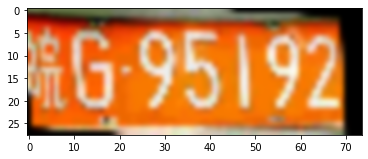

In [195]:
#Та же картинка после приведения к наименьшим в train датасете параметрам
plt.imshow(transforms.ToPILImage()(transforms.Resize((28, 74))(transforms.ToTensor()(max_img_h))), interpolation="bicubic")

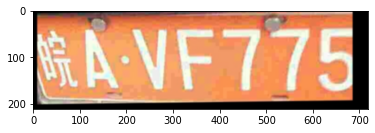

In [196]:
#Посмотрим на самую широкую картинку
plt.imshow(transforms.ToPILImage()(transforms.ToTensor()(max_img_w)), interpolation="bicubic")

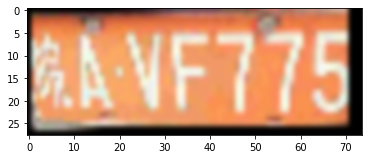

In [197]:
#Та же картинка после приведения к наименьшим в train датасете параметрам
plt.imshow(transforms.ToPILImage()(transforms.Resize((28, 74))(transforms.ToTensor()(max_img_w))), interpolation="bicubic")

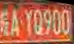

In [198]:
#Посмотрим на самую маленькую по ширине картинку
transforms.ToPILImage()(min_img_w)

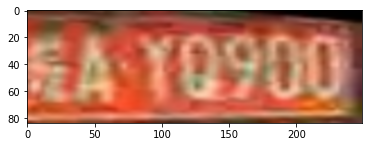

In [199]:
#Та же картинка после приведения к средним в train датасете параметрам
plt.imshow(transforms.ToPILImage()(transforms.Resize((84, 249))(transforms.ToTensor()(min_img_w))), interpolation="bicubic")

Лучше приводить к наименьшим размерам, так как даже самые высокие и широкие картинки несильно теряют в качестве по сравнению с растяжением

В качестве дефолтных трансформаций будем использовать ToTensor() и Resize((28, 74))

In [201]:
max_img_w.shape

(211, 719, 3)

In [202]:
transforms.ToTensor()(max_img_w).shape

torch.Size([3, 211, 719])

In [203]:
transforms.Resize((28, 74))(transforms.ToTensor()(max_img_w)).shape

torch.Size([3, 28, 74])

In [204]:
#Кодировщик лейблов в разреженный вектор
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

In [216]:
class PlateDetDataset(Dataset):
    def __init__(self, path=None, train=False, 
                 transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((28, 74))])
                ):
        super(Dataset, self).__init__()
        self.transform = transform
        self.train = train
        if path is None:
            return 'No path to file'
        else:
            self.data_path = path
            
            if self.train:
                self.train_file_names = [p for p in os.listdir(self.data_path + '/train')]
                self.train_labels = [p.split('-')[1].split('.')[0] for p in self.train_file_names]
            
            else:
                self.test_file_names = [p for p in os.listdir(self.data_path + '/test')]
                self.test_labels = [p.split('-')[1].split('.')[0] for p in self.test_file_names]

    def __len__(self):
        if self.train:
            return len(self.train_file_names)
        else:
            return len(self.test_file_names) 
                    
    def __getitem__(self, index):
        if self.train:
            self.label_train_en = []
            
            for i in self.train_labels[index]:
                self.label_train_en += encode(i)
                
            return self.transform(cv2.imread(self.data_path + '/train/' + self.train_file_names[index])), \
                   np.array(self.label_train_en), \
                   self.train_labels[index]
                   
        else:
            self.label_test_en = []
            
            for i in self.test_labels[index]:
                    self.label_test_en += encode(i)
                    
            return self.transform(cv2.imread(self.data_path + '/test/' + self.test_file_names[index])), \
                   np.array(self.label_test_en), \
                   self.test_labels[index]

In [318]:
#Сделаем dataloaders

train_dataset = PlateDetDataset(path=data_path, train=True)
data_train, data_val = torch.utils.data.random_split(
                            PlateDetDataset(path=data_path, train=True), 
                            [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)])
                        
data_test = PlateDetDataset(path=data_path, train=False)

try:
    #если картинки одинакового размера
    data_train_loader = DataLoader(data_train, batch_size=64, shuffle=True)
    data_val_loader = DataLoader(data_val, batch_size=64, shuffle=False)
    data_test_loader = DataLoader(data_test, batch_size=64, shuffle=False)
                                  
except: 
    #используется, если картинки разного размера
    def my_collate(batch):
        data = [item[0] for item in batch]
        target = [item[1] for item in batch]
        return [data, target]
           
    data_train_loader = DataLoader(data_train, batch_size=64, collate_fn=my_collate, shuffle=True)
    data_val_loader = DataLoader(data_val, batch_size=64, collate_fn=my_collate, shuffle=False)
    data_test_loader = DataLoader(data_test, batch_size=64, collate_fn=my_collate, shuffle=False)

In [218]:
data_train[0][0].shape

torch.Size([3, 28, 74])

In [219]:
#torch.Size([64, 462]) - BATCH_SIZE, ALL_CHAR_SET_LEN * PIC_WORD_LEN
for batch_idx, samples in enumerate(data_train_loader):
    print(batch_idx, samples[0].shape, samples[1].shape, len(samples[2]))
    break

0 torch.Size([64, 3, 28, 74]) torch.Size([64, 469]) 64


In [220]:
#torch.Size([64, 462]) - BATCH_SIZE, ALL_CHAR_SET_LEN * PIC_WORD_LEN
for batch_idx, samples in enumerate(data_test_loader):
    print(batch_idx, samples[0].shape, samples[1].shape, len(samples[2]))
    break

0 torch.Size([64, 3, 28, 74]) torch.Size([64, 469]) 64


In [221]:
len(data_train), len(data_val), len(data_test)

(159984, 39996, 9999)

Модель: Попробуем классическую сверточную нейросеть с остаточными (residule) слоями, она будет хуже rnn или трансформеров, но остается не очень много времени

In [376]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [379]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=64, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(64 * 3 * 9, 512)
        self.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_LEN, bias=True)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 64 * 3 * 9)
        out = torch.relu(self.fc1(out))
        out = self.fc(out)
        return out

In [380]:
#Проверим вывод для одной картинки
x = transforms.Resize((28, 74))(transforms.ToTensor()(max_img_h))
NetResDeep().forward(x.unsqueeze(0)).shape

torch.Size([1, 469])

In [382]:
from torchvision import models
import torch.nn as nn
# from fastai.vision import Path
import torch
from torch.autograd import Variable

MAX_LEN = 7 #число символов на картинке

# model = models.resnet18(pretrained=False)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_LEN, bias=True)
model = NetResDeep(n_blocks=100)
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.001)

#Обучение модели
#Очень долго считается без gru, поэтому стоит 1 эпоха
cnt_new = 0
for epoch in range(1):
    for step, i in enumerate(data_train_loader):
        img, label_oh, label = i
        img = Variable(img)
        label_oh = Variable(label_oh.float())
        pred = model(img)
        loss = loss_func(pred, label_oh)
        optm.zero_grad()
        loss.backward()
        optm.step()
        print('epoch:', epoch+1, 'step:', step+1, 'loss:', loss.item())


epoch: 1 step: 1 loss: 5.2739644050598145
epoch: 1 step: 2 loss: 2.0927109718322754
epoch: 1 step: 3 loss: 0.7895427346229553
epoch: 1 step: 4 loss: 0.3862074613571167
epoch: 1 step: 5 loss: 0.26654505729675293
epoch: 1 step: 6 loss: 0.23883454501628876
epoch: 1 step: 7 loss: 0.21945947408676147
epoch: 1 step: 8 loss: 0.1967751383781433
epoch: 1 step: 9 loss: 0.18641474843025208
epoch: 1 step: 10 loss: 0.19721664488315582
epoch: 1 step: 11 loss: 0.1918654590845108
epoch: 1 step: 12 loss: 0.1688743680715561
epoch: 1 step: 13 loss: 0.15318095684051514
epoch: 1 step: 14 loss: 0.13998320698738098
epoch: 1 step: 15 loss: 0.15275058150291443
epoch: 1 step: 16 loss: 0.14118629693984985
epoch: 1 step: 17 loss: 0.13254036009311676
epoch: 1 step: 18 loss: 0.1279297024011612
epoch: 1 step: 19 loss: 0.12145790457725525
epoch: 1 step: 20 loss: 0.1053079143166542
epoch: 1 step: 21 loss: 0.1011512503027916
epoch: 1 step: 22 loss: 0.10100069642066956
epoch: 1 step: 23 loss: 0.0855431854724884
epoch: 1

epoch: 1 step: 186 loss: 0.04605082795023918
epoch: 1 step: 187 loss: 0.046206191182136536
epoch: 1 step: 188 loss: 0.047791481018066406
epoch: 1 step: 189 loss: 0.04824972152709961
epoch: 1 step: 190 loss: 0.04494991898536682
epoch: 1 step: 191 loss: 0.04621496796607971
epoch: 1 step: 192 loss: 0.04646717756986618
epoch: 1 step: 193 loss: 0.045639194548130035
epoch: 1 step: 194 loss: 0.047189779579639435
epoch: 1 step: 195 loss: 0.046963825821876526
epoch: 1 step: 196 loss: 0.04637816920876503
epoch: 1 step: 197 loss: 0.04635254666209221
epoch: 1 step: 198 loss: 0.04719613492488861
epoch: 1 step: 199 loss: 0.04583339765667915
epoch: 1 step: 200 loss: 0.04656189680099487
epoch: 1 step: 201 loss: 0.04643982648849487
epoch: 1 step: 202 loss: 0.04451717808842659
epoch: 1 step: 203 loss: 0.04514254629611969
epoch: 1 step: 204 loss: 0.04447520524263382
epoch: 1 step: 205 loss: 0.04452105984091759
epoch: 1 step: 206 loss: 0.04579523950815201
epoch: 1 step: 207 loss: 0.04636283218860626
epoch

epoch: 1 step: 368 loss: 0.0440002903342247
epoch: 1 step: 369 loss: 0.043782953172922134
epoch: 1 step: 370 loss: 0.04162447899580002
epoch: 1 step: 371 loss: 0.04472590237855911
epoch: 1 step: 372 loss: 0.044811055064201355
epoch: 1 step: 373 loss: 0.04282843694090843
epoch: 1 step: 374 loss: 0.04279287904500961
epoch: 1 step: 375 loss: 0.04371024668216705
epoch: 1 step: 376 loss: 0.042671624571084976
epoch: 1 step: 377 loss: 0.04460371658205986
epoch: 1 step: 378 loss: 0.04592343792319298
epoch: 1 step: 379 loss: 0.04443011432886124
epoch: 1 step: 380 loss: 0.04545610770583153
epoch: 1 step: 381 loss: 0.04281718283891678
epoch: 1 step: 382 loss: 0.043818093836307526
epoch: 1 step: 383 loss: 0.04227074980735779
epoch: 1 step: 384 loss: 0.04498538002371788
epoch: 1 step: 385 loss: 0.043517276644706726
epoch: 1 step: 386 loss: 0.042491935193538666
epoch: 1 step: 387 loss: 0.04478130862116814
epoch: 1 step: 388 loss: 0.04308623448014259
epoch: 1 step: 389 loss: 0.045024845749139786
epoc

epoch: 1 step: 550 loss: 0.036032818257808685
epoch: 1 step: 551 loss: 0.03610687702894211
epoch: 1 step: 552 loss: 0.03742896020412445
epoch: 1 step: 553 loss: 0.035154037177562714
epoch: 1 step: 554 loss: 0.035345032811164856
epoch: 1 step: 555 loss: 0.035697221755981445
epoch: 1 step: 556 loss: 0.03570441156625748
epoch: 1 step: 557 loss: 0.03634542599320412
epoch: 1 step: 558 loss: 0.03489668667316437
epoch: 1 step: 559 loss: 0.03526591137051582
epoch: 1 step: 560 loss: 0.03424936905503273
epoch: 1 step: 561 loss: 0.034708522260189056
epoch: 1 step: 562 loss: 0.033871907740831375
epoch: 1 step: 563 loss: 0.03434973582625389
epoch: 1 step: 564 loss: 0.03607810288667679
epoch: 1 step: 565 loss: 0.03389941155910492
epoch: 1 step: 566 loss: 0.034291066229343414
epoch: 1 step: 567 loss: 0.03326823189854622
epoch: 1 step: 568 loss: 0.03515808284282684
epoch: 1 step: 569 loss: 0.03605283424258232
epoch: 1 step: 570 loss: 0.034421131014823914
epoch: 1 step: 571 loss: 0.033805280923843384
e

epoch: 1 step: 731 loss: 0.02663416787981987
epoch: 1 step: 732 loss: 0.026504874229431152
epoch: 1 step: 733 loss: 0.024423904716968536
epoch: 1 step: 734 loss: 0.024686353281140327
epoch: 1 step: 735 loss: 0.024056605994701385
epoch: 1 step: 736 loss: 0.023853672668337822
epoch: 1 step: 737 loss: 0.026479410007596016
epoch: 1 step: 738 loss: 0.024051930755376816
epoch: 1 step: 739 loss: 0.02488895319402218
epoch: 1 step: 740 loss: 0.02629649080336094
epoch: 1 step: 741 loss: 0.025022707879543304
epoch: 1 step: 742 loss: 0.024789942428469658
epoch: 1 step: 743 loss: 0.023287782445549965
epoch: 1 step: 744 loss: 0.025423480197787285
epoch: 1 step: 745 loss: 0.0252350103110075
epoch: 1 step: 746 loss: 0.025939472019672394
epoch: 1 step: 747 loss: 0.0247474554926157
epoch: 1 step: 748 loss: 0.027409441769123077
epoch: 1 step: 749 loss: 0.02443562261760235
epoch: 1 step: 750 loss: 0.025790100917220116
epoch: 1 step: 751 loss: 0.025535540655255318
epoch: 1 step: 752 loss: 0.026197636500000

epoch: 1 step: 911 loss: 0.01847391203045845
epoch: 1 step: 912 loss: 0.017502207309007645
epoch: 1 step: 913 loss: 0.01764696277678013
epoch: 1 step: 914 loss: 0.01819770410656929
epoch: 1 step: 915 loss: 0.01757451891899109
epoch: 1 step: 916 loss: 0.01655539870262146
epoch: 1 step: 917 loss: 0.019776787608861923
epoch: 1 step: 918 loss: 0.018563512712717056
epoch: 1 step: 919 loss: 0.016166843473911285
epoch: 1 step: 920 loss: 0.017302600666880608
epoch: 1 step: 921 loss: 0.018490508198738098
epoch: 1 step: 922 loss: 0.017389841377735138
epoch: 1 step: 923 loss: 0.017972353845834732
epoch: 1 step: 924 loss: 0.016663771122694016
epoch: 1 step: 925 loss: 0.01752195507287979
epoch: 1 step: 926 loss: 0.016570700332522392
epoch: 1 step: 927 loss: 0.01673983782529831
epoch: 1 step: 928 loss: 0.018576378002762794
epoch: 1 step: 929 loss: 0.01647418923676014
epoch: 1 step: 930 loss: 0.01727462001144886
epoch: 1 step: 931 loss: 0.020742105320096016
epoch: 1 step: 932 loss: 0.0199671909213066

epoch: 1 step: 1089 loss: 0.014218438416719437
epoch: 1 step: 1090 loss: 0.017465120181441307
epoch: 1 step: 1091 loss: 0.013828359544277191
epoch: 1 step: 1092 loss: 0.013406474143266678
epoch: 1 step: 1093 loss: 0.013414975255727768
epoch: 1 step: 1094 loss: 0.015299866907298565
epoch: 1 step: 1095 loss: 0.014780963771045208
epoch: 1 step: 1096 loss: 0.014515780843794346
epoch: 1 step: 1097 loss: 0.014894322492182255
epoch: 1 step: 1098 loss: 0.013841464184224606
epoch: 1 step: 1099 loss: 0.013917970471084118
epoch: 1 step: 1100 loss: 0.013529917225241661
epoch: 1 step: 1101 loss: 0.016276441514492035
epoch: 1 step: 1102 loss: 0.014392542652785778
epoch: 1 step: 1103 loss: 0.01402115635573864
epoch: 1 step: 1104 loss: 0.014089158736169338
epoch: 1 step: 1105 loss: 0.015048089437186718
epoch: 1 step: 1106 loss: 0.012756087817251682
epoch: 1 step: 1107 loss: 0.013785572722554207
epoch: 1 step: 1108 loss: 0.0126337930560112
epoch: 1 step: 1109 loss: 0.012432453222572803
epoch: 1 step: 1

epoch: 1 step: 1265 loss: 0.013146837241947651
epoch: 1 step: 1266 loss: 0.010102163068950176
epoch: 1 step: 1267 loss: 0.0119943767786026
epoch: 1 step: 1268 loss: 0.010255117900669575
epoch: 1 step: 1269 loss: 0.012126411311328411
epoch: 1 step: 1270 loss: 0.01136585883796215
epoch: 1 step: 1271 loss: 0.010660262778401375
epoch: 1 step: 1272 loss: 0.011019725352525711
epoch: 1 step: 1273 loss: 0.01210043951869011
epoch: 1 step: 1274 loss: 0.010614931583404541
epoch: 1 step: 1275 loss: 0.011708399280905724
epoch: 1 step: 1276 loss: 0.011151807382702827
epoch: 1 step: 1277 loss: 0.010835682973265648
epoch: 1 step: 1278 loss: 0.01067361794412136
epoch: 1 step: 1279 loss: 0.011377440765500069
epoch: 1 step: 1280 loss: 0.01272617932409048
epoch: 1 step: 1281 loss: 0.012658491730690002
epoch: 1 step: 1282 loss: 0.011509982869029045
epoch: 1 step: 1283 loss: 0.012433834373950958
epoch: 1 step: 1284 loss: 0.010845724493265152
epoch: 1 step: 1285 loss: 0.01053630281239748
epoch: 1 step: 1286 

epoch: 1 step: 1441 loss: 0.009590018540620804
epoch: 1 step: 1442 loss: 0.010133044794201851
epoch: 1 step: 1443 loss: 0.009322532452642918
epoch: 1 step: 1444 loss: 0.009974822402000427
epoch: 1 step: 1445 loss: 0.00980865117162466
epoch: 1 step: 1446 loss: 0.011303110979497433
epoch: 1 step: 1447 loss: 0.012562855146825314
epoch: 1 step: 1448 loss: 0.010807103477418423
epoch: 1 step: 1449 loss: 0.010135645046830177
epoch: 1 step: 1450 loss: 0.009806644171476364
epoch: 1 step: 1451 loss: 0.012710553593933582
epoch: 1 step: 1452 loss: 0.009816084988415241
epoch: 1 step: 1453 loss: 0.011141850613057613
epoch: 1 step: 1454 loss: 0.009914778172969818
epoch: 1 step: 1455 loss: 0.010247902944684029
epoch: 1 step: 1456 loss: 0.010812274180352688
epoch: 1 step: 1457 loss: 0.009578145109117031
epoch: 1 step: 1458 loss: 0.010589780285954475
epoch: 1 step: 1459 loss: 0.008922988548874855
epoch: 1 step: 1460 loss: 0.009145203977823257
epoch: 1 step: 1461 loss: 0.01181047409772873
epoch: 1 step: 

epoch: 1 step: 1616 loss: 0.008977236226201057
epoch: 1 step: 1617 loss: 0.008069245144724846
epoch: 1 step: 1618 loss: 0.007475710939615965
epoch: 1 step: 1619 loss: 0.008483806625008583
epoch: 1 step: 1620 loss: 0.007828855887055397
epoch: 1 step: 1621 loss: 0.008802508935332298
epoch: 1 step: 1622 loss: 0.00806315429508686
epoch: 1 step: 1623 loss: 0.00724383071064949
epoch: 1 step: 1624 loss: 0.007837778888642788
epoch: 1 step: 1625 loss: 0.00870509073138237
epoch: 1 step: 1626 loss: 0.009121067821979523
epoch: 1 step: 1627 loss: 0.008172210305929184
epoch: 1 step: 1628 loss: 0.007916239090263844
epoch: 1 step: 1629 loss: 0.007344033569097519
epoch: 1 step: 1630 loss: 0.007628200575709343
epoch: 1 step: 1631 loss: 0.00859925802797079
epoch: 1 step: 1632 loss: 0.006715104449540377
epoch: 1 step: 1633 loss: 0.008858288638293743
epoch: 1 step: 1634 loss: 0.008639149367809296
epoch: 1 step: 1635 loss: 0.007112682797014713
epoch: 1 step: 1636 loss: 0.007876363582909107
epoch: 1 step: 16

epoch: 1 step: 1791 loss: 0.006867183372378349
epoch: 1 step: 1792 loss: 0.006348484195768833
epoch: 1 step: 1793 loss: 0.01003343053162098
epoch: 1 step: 1794 loss: 0.005265234038233757
epoch: 1 step: 1795 loss: 0.006788699422031641
epoch: 1 step: 1796 loss: 0.005914520472288132
epoch: 1 step: 1797 loss: 0.006925330497324467
epoch: 1 step: 1798 loss: 0.006331792101264
epoch: 1 step: 1799 loss: 0.00521707721054554
epoch: 1 step: 1800 loss: 0.006282010115683079
epoch: 1 step: 1801 loss: 0.006381407380104065
epoch: 1 step: 1802 loss: 0.005950247403234243
epoch: 1 step: 1803 loss: 0.006277013570070267
epoch: 1 step: 1804 loss: 0.006679164245724678
epoch: 1 step: 1805 loss: 0.005922066979110241
epoch: 1 step: 1806 loss: 0.006648939568549395
epoch: 1 step: 1807 loss: 0.005703769624233246
epoch: 1 step: 1808 loss: 0.005960248876363039
epoch: 1 step: 1809 loss: 0.007615839131176472
epoch: 1 step: 1810 loss: 0.0061098672449588776
epoch: 1 step: 1811 loss: 0.008342760615050793
epoch: 1 step: 18

epoch: 1 step: 1966 loss: 0.005745511502027512
epoch: 1 step: 1967 loss: 0.0051193214021623135
epoch: 1 step: 1968 loss: 0.007562830578535795
epoch: 1 step: 1969 loss: 0.004802766256034374
epoch: 1 step: 1970 loss: 0.005993274040520191
epoch: 1 step: 1971 loss: 0.0037388158962130547
epoch: 1 step: 1972 loss: 0.00594171229749918
epoch: 1 step: 1973 loss: 0.004777021240442991
epoch: 1 step: 1974 loss: 0.006314011290669441
epoch: 1 step: 1975 loss: 0.005369280930608511
epoch: 1 step: 1976 loss: 0.004483235999941826
epoch: 1 step: 1977 loss: 0.006286227609962225
epoch: 1 step: 1978 loss: 0.006065080873668194
epoch: 1 step: 1979 loss: 0.0052862283773720264
epoch: 1 step: 1980 loss: 0.0058097536675632
epoch: 1 step: 1981 loss: 0.005228289403021336
epoch: 1 step: 1982 loss: 0.005512953270226717
epoch: 1 step: 1983 loss: 0.004002352710813284
epoch: 1 step: 1984 loss: 0.005204745102673769
epoch: 1 step: 1985 loss: 0.004548222292214632
epoch: 1 step: 1986 loss: 0.004808075726032257
epoch: 1 step

epoch: 1 step: 2141 loss: 0.005396516062319279
epoch: 1 step: 2142 loss: 0.004170463420450687
epoch: 1 step: 2143 loss: 0.004666418768465519
epoch: 1 step: 2144 loss: 0.005061602219939232
epoch: 1 step: 2145 loss: 0.0036116938572376966
epoch: 1 step: 2146 loss: 0.003503818064928055
epoch: 1 step: 2147 loss: 0.005032410845160484
epoch: 1 step: 2148 loss: 0.0040191966108977795
epoch: 1 step: 2149 loss: 0.005329834297299385
epoch: 1 step: 2150 loss: 0.0036546741612255573
epoch: 1 step: 2151 loss: 0.00562497042119503
epoch: 1 step: 2152 loss: 0.003992867656052113
epoch: 1 step: 2153 loss: 0.0039408341981470585
epoch: 1 step: 2154 loss: 0.00467645563185215
epoch: 1 step: 2155 loss: 0.005101628135889769
epoch: 1 step: 2156 loss: 0.005293815862387419
epoch: 1 step: 2157 loss: 0.004078684374690056
epoch: 1 step: 2158 loss: 0.00611237995326519
epoch: 1 step: 2159 loss: 0.0046105473302304745
epoch: 1 step: 2160 loss: 0.004703161306679249
epoch: 1 step: 2161 loss: 0.005604309029877186
epoch: 1 st

epoch: 1 step: 2315 loss: 0.003917159978300333
epoch: 1 step: 2316 loss: 0.003914540633559227
epoch: 1 step: 2317 loss: 0.004739704541862011
epoch: 1 step: 2318 loss: 0.004327223636209965
epoch: 1 step: 2319 loss: 0.004562183283269405
epoch: 1 step: 2320 loss: 0.0031602371018379927
epoch: 1 step: 2321 loss: 0.004567562602460384
epoch: 1 step: 2322 loss: 0.003749759402126074
epoch: 1 step: 2323 loss: 0.004135574214160442
epoch: 1 step: 2324 loss: 0.0037324433214962482
epoch: 1 step: 2325 loss: 0.0031970005948096514
epoch: 1 step: 2326 loss: 0.005044030025601387
epoch: 1 step: 2327 loss: 0.006093746051192284
epoch: 1 step: 2328 loss: 0.003791702212765813
epoch: 1 step: 2329 loss: 0.004363995045423508
epoch: 1 step: 2330 loss: 0.004311110358685255
epoch: 1 step: 2331 loss: 0.005271118134260178
epoch: 1 step: 2332 loss: 0.004444148391485214
epoch: 1 step: 2333 loss: 0.005672341212630272
epoch: 1 step: 2334 loss: 0.005265706218779087
epoch: 1 step: 2335 loss: 0.0042932708747684956
epoch: 1 

epoch: 1 step: 2489 loss: 0.0027209664694964886
epoch: 1 step: 2490 loss: 0.004158376716077328
epoch: 1 step: 2491 loss: 0.004608082585036755
epoch: 1 step: 2492 loss: 0.002816480817273259
epoch: 1 step: 2493 loss: 0.003016311675310135
epoch: 1 step: 2494 loss: 0.0026756608858704567
epoch: 1 step: 2495 loss: 0.003271259367465973
epoch: 1 step: 2496 loss: 0.004935352131724358
epoch: 1 step: 2497 loss: 0.0037575310561805964
epoch: 1 step: 2498 loss: 0.004013530444353819
epoch: 1 step: 2499 loss: 0.0039054432418197393
epoch: 1 step: 2500 loss: 0.0026149749755859375


In [383]:
#Теперь прогоним на test датасете
model.eval();
cnt, mean_acc, mean_CER = 0, 0, 0
for step, (img, label_oh, label) in enumerate(data_test_loader):
    img = Variable(img)
    pred = model(img)
    pred = torch.reshape(pred, (pred.shape[0], MAX_LEN, ALL_CHAR_SET_LEN))
    max_elems = torch.max(pred, 2)[1]
    pred_l = [''.join([ALL_CHAR_SET[i] for i in max_elems[j, :]]) for j in range(max_elems.shape[0])]
    metric = CharErrorRate()
    mean_acc += accuracy(pred_l, label)
    mean_CER += metric(pred_l, label)
#     print(f'CharErrorRate: {metric(pred_l, label)}, Accuracy: {accuracy(pred_l, label)}')
    cnt += 1
print(f'CharErrorRate: {mean_CER/cnt}, Accuracy: {mean_acc/cnt}')

CharErrorRate: 0.6857007741928101, Accuracy: 0.0


In [385]:
#сохраним веса модели
torch.save(model.state_dict(), '/Users/alenabuk/Tink_saved_model/tink_model.pt')

In [402]:
#Модель переобучилась
pred_l[0:10]

['皖AK889F',
 '皖AK889F',
 '皖AK809F',
 '皖AK889F',
 '皖AK889F',
 '皖AK889F',
 '皖AK889F',
 '皖AK889F',
 '皖AK889F',
 '皖AK889F']

Так делать не стоило

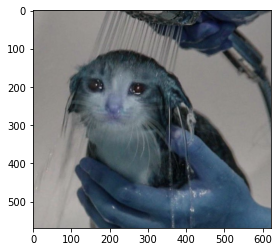

In [405]:
img = cv2.imread('/Users/alenabuk/Downloads/funny-sad-cat-Favim.com-7790179.jpg')
plt.imshow(img)

Но на models.resnet18 вообще неплохо выходило, где-то 0.9 accuracy, ~0.14 CharErrorRate, просто тут реализация не такой хорошей получилась 